In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import soundfile as sf
import librosa

from build_model import build_model, myconf
from test_result import find_file, write_eval, resynthesis, mse, write_eval_latex, mse_stft


In [2]:
# path
data_dir = '/Users/xiaoyu/WorkStation/Project_rvae/Data/clean_speech/wsj0_si_et_05'
root_dir = '/Users/xiaoyu/WorkStation/Project_rvae/saved_model_Xiaoyu/'

male_audio_idx = 0
female_audio_idx = 0
male_dir = '440'
female_dir = '441'
male_files = ['440c020a.wav', '440c020b.wav', '440c020c.wav', '440c020d.wav', '440c020e.wav']
female_files = ['441c020a.wav', '441c020b.wav', '441c020c.wav', '441c020d.wav', '441c020e.wav']

ffnn_dir = 'WSJ0_2020-02-26-15h07_FFNN_z_dim=16'
rnn_NoRec_dir = 'WSJ0_2020-02-22-12h32_UniEnc_UniDec_NoRecZ_z_dim=16'
rnn_Rec_dir = 'WSJ0_2020-02-22-17h12_UniEnc_UniDec_RecZ_z_dim=16'
brnn_NoRec_dir = 'WSJ0_2020-02-22-23h55_BiEnc_BiDec_NoRecZ_z_dim=16'
brnn_Rec_dir = 'WSJ0_2020-02-23-05h22_BiEnc_BiDec_RecZ_z_dim=16'

In [3]:
# STFT parameters
wlen_sec = 64e-3
hop_percent = 0.25
fs = 16000
zp_percent = 0
trim = True
verbose = False
nfft = np.int(np.power(2, np.ceil(np.log2(wlen_sec * fs))))
wlen = nfft
hop = np.int(hop_percent * wlen)
win = np.sin(np.arange(0.5, wlen+0.5) / wlen * np.pi)

In [4]:
# Re-synthesis files
audio_list_orig = []
audio_list_recon = []
for i in range(5):
    audio_list_orig.append('male_440_origin-{}.wav'.format(i))
    audio_list_recon.append('male_440_recon-{}.wav'.format(i))
for i in range(5):
    audio_list_orig.append('female_441_origin-{}.wav'.format(i))
    audio_list_recon.append('female_441_recon-{}.wav'.format(i))
model_list = [ffnn_dir, rnn_NoRec_dir, rnn_Rec_dir, brnn_NoRec_dir, brnn_Rec_dir]
model_tag = ['FFNN', 'UniRNN NoRecZ', 'UniRNN RecZ', 'BiRNN NoRecZ', 'BiRNN RecZ']

In [5]:
# Analyse on re-synthesis wav file (may have scale problem)
eval_time_list = []
eval_mag_list = []
for i in range(5):
    eval_dic_time = {'mse': []}
    eval_dic_mag = {'mse': []}
    for j in range(10):
        file_orig = os.path.join(root_dir, model_list[i], 'test', audio_list_orig[j])
        file_recon = os.path.join(root_dir, model_list[i], 'test', audio_list_recon[j])
        x_orig, _ = sf.read(file_orig)
        x_recon, _ = sf.read(file_recon)
        X_orig = librosa.stft(x_orig, n_fft=nfft, hop_length=hop, win_length=wlen, window=win)
        X_recon = librosa.stft(x_recon, n_fft=nfft, hop_length=hop, win_length=wlen, window=win)
        mag_orig = np.abs(X_orig) ** 2 
        mag_recon = np.abs(X_recon) ** 2
        X_norm = X_orig.sum(axis=1)
        
        len_x = len(x_recon)
        mse_time = '{:.6f}'.format(mse(x_orig[:len_x], x_recon))
        mse_mag = '{:.3f}'.format(mse_stft(X_orig, X_recon))
        eval_dic_time['mse'].append(mse_time)
        eval_dic_mag['mse'].append(mse_mag)
    eval_time_list.append(eval_dic_time)
    eval_mag_list.append(eval_dic_mag)   

male_audios = ['440c020a.wav', '440c020b.wav', '440c020c.wav', '440c020d.wav', '440c020e.wav']
female_audios = ['441c020a.wav', '441c020b.wav', '441c020c.wav', '441c020d.wav', '441c020e.wav']
audio_list = male_audios + female_audios

write_eval_latex(root_dir, eval_mag_list, model_tag, audio_list)

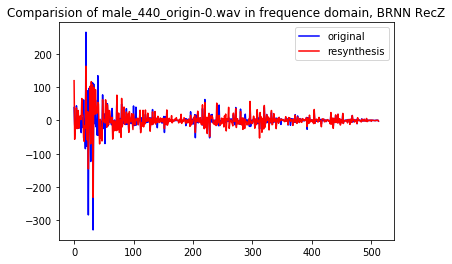

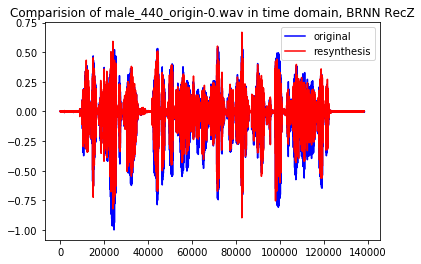

In [62]:
# Look at diffenrece in time domain and in Fourier domain
from build_model import build_model
from test_result import find_file
from evaluation.write_eval import write_eval, write_eval_latex
from evaluation.loss_mse import mse_td, mse_mag

file = os.path.join(data_dir, male_dir, male_files[0])
train_dir = os.path.join(root_dir, brnn_Rec_dir)
cfg_file, weight_file = find_file(train_dir)
model_class = build_model(cfg_file)
model = model_class.model
cfg = model_class.cfg
local_device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load weight
model.load_state_dict(torch.load(weight_file, map_location=local_device))
model.eval()
if local_device == 'cuda':
    model.cuda()
    
x, fs_x = sf.read(file)
x = x / np.max(np.abs(x)) 
X = librosa.stft(x, n_fft=nfft, hop_length=hop, win_length=wlen, window=win) # stft

# x_dim: nfft/2 + 1
# seq_len: number of frames
data_orig = np.abs(X) ** 2 # (x_dim, seq_len)
data_orig = torch.from_numpy(data_orig.astype(np.float32))
data_orig = data_orig.to(local_device)
data_orig = data_orig.T # (seq_len, x_dim), adapted to torch layers


# model output: (seq_len, data_dim)
# recon need: (data_dim, seq_len)
with torch.no_grad():
    data_recon, mean, logvar, z = model(data_orig)
    mean = mean.detach().numpy().T
    data_recon = data_recon.detach().numpy().T
    data_orig = data_orig.detach().numpy().T

X_recon = np.sqrt(data_recon) * np.exp(1j * np.angle(X))
x_recon = librosa.istft(X_recon, hop_length=hop, win_length=wlen, window=win)
x_orig = x

X_feq_orig = X_orig.sum(axis=1)
X_feq_recon = X_recon.sum(axis=1)

plt.figure(1)
plt.plot(X_feq_orig, 'b', label='original')
plt.plot(X_feq_recon, 'r', label='resynthesis')
plt.legend(loc='upper right')
plt.title('Comparision of male_440_origin-0.wav in frequence domain, BRNN RecZ')
plt.savefig('/Users/xiaoyu/WorkStation/Project_rvae/saved_model_Xiaoyu/brnn_FD.png')


plt.figure(2)
plt.plot(x_orig, 'b', label='original')
plt.plot(x_recon, 'r', label='resynthesis')
plt.legend(loc='upper right')
plt.title('Comparision of male_440_origin-0.wav in time domain, BRNN RecZ')
plt.savefig('/Users/xiaoyu/WorkStation/Project_rvae/saved_model_Xiaoyu/brnn_TD.png')
plt.show()

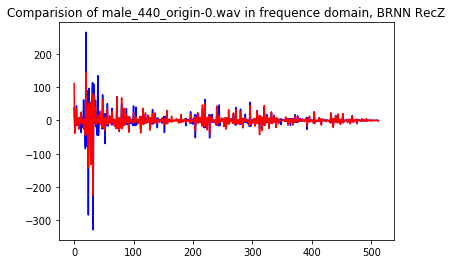

In [34]:
import matplotlib.pyplot as plt



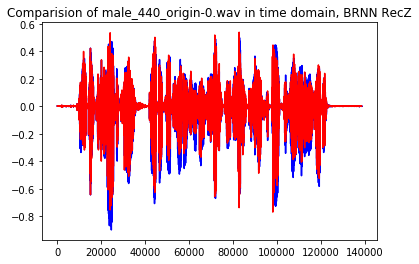

'a{1}'